In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import Levenshtein as lev
import os
import gc

In [ ]:
pad_token = 'P'
start_token = 'S'
end_token = 'E'
pad_token_idx = 59
start_token_idx = 60
end_token_idx = 61

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
with open ("/content/drive/MyDrive/Dataset/asl-fingerspelling/character_to_prediction_index.json", "r") as f:
    char_to_num = json.load(f)

char_to_num[pad_token] = pad_token_idx
char_to_num[start_token] = start_token_idx
char_to_num[end_token] = end_token_idx
num_to_char = {j:i for i,j in char_to_num.items()}

inpdir = "/content/drive/MyDrive/Dataset/asl-fingerspelling"
df = pd.read_csv(f'{inpdir}/train.csv')

LPOSE = [13, 15, 17, 19, 21]
RPOSE = [14, 16, 18, 20, 22]
POSE = LPOSE + RPOSE

RHAND_LBLS = [f'x_right_hand_{i}' for i in range(21)] + [f'y_right_hand_{i}' for i in range(21)] + [f'z_right_hand_{i}' for i in range(21)]
LHAND_LBLS = [ f'x_left_hand_{i}' for i in range(21)] + [ f'y_left_hand_{i}' for i in range(21)] + [ f'z_left_hand_{i}' for i in range(21)]
POSE_LBLS = [f'x_pose_{i}' for i in POSE] + [f'y_pose_{i}' for i in POSE] + [f'z_pose_{i}' for i in POSE]

X = [f'x_right_hand_{i}' for i in range(21)] + [f'x_left_hand_{i}' for i in range(21)] + [f'x_pose_{i}' for i in POSE]
Y = [f'y_right_hand_{i}' for i in range(21)] + [f'y_left_hand_{i}' for i in range(21)] + [f'y_pose_{i}' for i in POSE]
Z = [f'z_right_hand_{i}' for i in range(21)] + [f'z_left_hand_{i}' for i in range(21)] + [f'z_pose_{i}' for i in POSE]

SEL_COLS = X + Y + Z
FRAME_LEN = 128

X_IDX = [i for i, col in enumerate(SEL_COLS)  if "x_" in col]
Y_IDX = [i for i, col in enumerate(SEL_COLS)  if "y_" in col]
Z_IDX = [i for i, col in enumerate(SEL_COLS)  if "z_" in col]

RHAND_IDX = [i for i, col in enumerate(SEL_COLS)  if "right" in col]
LHAND_IDX = [i for i, col in enumerate(SEL_COLS)  if  "left" in col]
RPOSE_IDX = [i for i, col in enumerate(SEL_COLS)  if  "pose" in col and int(col[-2:]) in RPOSE]
LPOSE_IDX = [i for i, col in enumerate(SEL_COLS)  if  "pose" in col and int(col[-2:]) in LPOSE]

In [ ]:
def resize_pad(x):
    if tf.shape(x)[0] < FRAME_LEN:
        x = tf.pad(x, ([[0, FRAME_LEN-tf.shape(x)[0]], [0, 0], [0, 0]]))
    else:
        x = tf.image.resize(x, (FRAME_LEN, tf.shape(x)[1]))
    return x

def pre_process(x):
    rhand = tf.gather(x, RHAND_IDX, axis=1)
    lhand = tf.gather(x, LHAND_IDX, axis=1)
    rpose = tf.gather(x, RPOSE_IDX, axis=1)
    lpose = tf.gather(x, LPOSE_IDX, axis=1)

    rnan_idx = tf.reduce_any(tf.math.is_nan(rhand), axis=1)
    lnan_idx = tf.reduce_any(tf.math.is_nan(lhand), axis=1)

    rnans = tf.math.count_nonzero(rnan_idx)
    lnans = tf.math.count_nonzero(lnan_idx)

    # For dominant hand
    if rnans > lnans:
        hand = lhand
        pose = lpose

        hand_x = hand[:, 0*(len(LHAND_IDX)//3) : 1*(len(LHAND_IDX)//3)]
        hand_y = hand[:, 1*(len(LHAND_IDX)//3) : 2*(len(LHAND_IDX)//3)]
        hand_z = hand[:, 2*(len(LHAND_IDX)//3) : 3*(len(LHAND_IDX)//3)]
        hand = tf.concat([1-hand_x, hand_y, hand_z], axis=1)

        pose_x = pose[:, 0*(len(LPOSE_IDX)//3) : 1*(len(LPOSE_IDX)//3)]
        pose_y = pose[:, 1*(len(LPOSE_IDX)//3) : 2*(len(LPOSE_IDX)//3)]
        pose_z = pose[:, 2*(len(LPOSE_IDX)//3) : 3*(len(LPOSE_IDX)//3)]
        pose = tf.concat([1-pose_x, pose_y, pose_z], axis=1)
    else:
        hand = rhand
        pose = rpose

    hand_x = hand[:, 0*(len(LHAND_IDX)//3) : 1*(len(LHAND_IDX)//3)]
    hand_y = hand[:, 1*(len(LHAND_IDX)//3) : 2*(len(LHAND_IDX)//3)]
    hand_z = hand[:, 2*(len(LHAND_IDX)//3) : 3*(len(LHAND_IDX)//3)]
    hand = tf.concat([hand_x[..., tf.newaxis], hand_y[..., tf.newaxis], hand_z[..., tf.newaxis]], axis=-1)

    mean = tf.math.reduce_mean(hand, axis=1)[:, tf.newaxis, :]
    std = tf.math.reduce_std(hand, axis=1)[:, tf.newaxis, :]
    hand = (hand - mean) / std

    pose_x = pose[:, 0*(len(LPOSE_IDX)//3) : 1*(len(LPOSE_IDX)//3)]
    pose_y = pose[:, 1*(len(LPOSE_IDX)//3) : 2*(len(LPOSE_IDX)//3)]
    pose_z = pose[:, 2*(len(LPOSE_IDX)//3) : 3*(len(LPOSE_IDX)//3)]
    pose = tf.concat([pose_x[..., tf.newaxis], pose_y[..., tf.newaxis], pose_z[..., tf.newaxis]], axis=-1)

    x = tf.concat([hand, pose], axis=1)
    x = resize_pad(x)

    x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)
    x = tf.reshape(x, (FRAME_LEN, len(LHAND_IDX) + len(LPOSE_IDX)))
    return x

In [ ]:
table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=list(char_to_num.keys()),
        values=list(char_to_num.values()),
    ),
    default_value=tf.constant(-1),
    name="class_weight"
)

def preprocess_fn(landmarks, phrase):
    phrase = start_token + phrase + end_token
    phrase = tf.strings.bytes_split(phrase)
    phrase = table.lookup(phrase)
    phrase = tf.pad(phrase, paddings=[[0, 64 - tf.shape(phrase)[0]]], mode = 'CONSTANT',
                    constant_values = pad_token_idx)
    return pre_process(landmarks), phrase

def decode_fn(record_bytes):
    schema = {COL: tf.io.VarLenFeature(dtype=tf.float32) for COL in SEL_COLS}
    schema["phrase"] = tf.io.FixedLenFeature([], dtype=tf.string)
    features = tf.io.parse_single_example(record_bytes, schema)
    phrase = features["phrase"]
    landmarks = ([tf.sparse.to_dense(features[COL]) for COL in SEL_COLS])
    landmarks = tf.transpose(landmarks)

    return landmarks, phrase

inpdir = "/content/drive/MyDrive/Dataset/asl-fingerspelling"
tffiles = df.file_id.map(lambda x: f'{inpdir}/tfds/{x}.tfrecord').unique()

batch_size = 32
val_len = int(0.05 * len(tffiles))

train_dataset = tf.data.TFRecordDataset(tffiles[val_len:]).map(decode_fn).map(preprocess_fn).shuffle(30000, reshuffle_each_iteration=True).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = tf.data.TFRecordDataset(tffiles[:val_len]).map(decode_fn).map(preprocess_fn).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:


def positional_enc(len: int,depth: int):
  depth=depth/2
  position=tf.range(len,dtype=tf.float32)[...,tf.newaxis]
  depths=tf.range(depth,dtype=tf.float32)[np.newaxis,:]/depth
  angles_rates=tf.math.divide(1, tf.math.pow(tf.cast(10000, tf.float32), depths))
  angles_rads=tf.linalg.matmul(position, angles_rates)
  pos_enc=tf.concat(
          [tf.math.sin(angles_rads), tf.math.cos(angles_rads)],
          axis=-1)
  return pos_enc

class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, d_model=64, maxlen=100):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv1D(
            d_model, 11, padding="same", activation="relu"
        )
        self.conv2 = tf.keras.layers.Conv1D(
            d_model, 11, padding="same", activation="relu"
        )
        self.conv3 = tf.keras.layers.Conv1D(
            d_model, 11, padding="same", activation="relu"
        )

        # self.pos_emb = positional_enc(maxlen, d_model)
        self.maxlen = maxlen
        self.d_model=d_model

  def call(self, x):

      x = self.conv1(x)
      x = self.conv2(x)
      x = self.conv3(x)
      self.pos_emb = positional_enc(x.shape[1], self.d_model)
      x = tf.math.multiply(x, tf.math.sqrt(tf.cast(self.d_model, tf.float32)))
      x = x + self.pos_emb

      return x






In [ ]:
class PositionalEmbeddingForDec(tf.keras.layers.Layer):
  def __init__(self,vocab_size: int,d_model: int,embedding: tf.keras.layers.Embedding=None):
    super().__init__()
    self.d_model=d_model
    self.embedding=tf.keras.layers.Embedding(vocab_size,d_model,mask_zero=True) if embedding is None else embedding
    self.pos_encode=positional_enc(len=vocab_size-1,depth=d_model)
  def compute_mask(self,*args,**kargs):
    return self.embedding.compute_mask(*args,**kargs)

  def call (self, x:tf.Tensor) -> tf.Tensor:

    x=self.embedding(x)
    len=tf.shape(x)[-1]
    x = tf.math.multiply(x, tf.math.sqrt(tf.cast(self.d_model, tf.float32)))
    # print(tf.shape(x))
    x=x+self.pos_encode[:len,:]
    return x

In [ ]:
pos=PositionalEmbedding(100,128)
rand_ts=tf.cast(np.random.randint(0,1000,size=(1,128,78)),tf.float32)
print(rand_ts)
pos(rand_ts)

In [ ]:
class BaseAttention(tf.keras.layers.Layer):

  def __init__(self,**kargs:dict):
    super().__init__()
    self.mha=tf.keras.layers.MultiHeadAttention(**kargs)
    self.layer_norm=tf.keras.layers.LayerNormalization()
    self.add=tf.keras.layers.Add()

class CrossAttention(BaseAttention):
  def call(self,x:tf.Tensor,context:tf.Tensor)->tf.Tensor:
    at_output,at_score=self.mha(query=x,key=context,value=context,return_attention_scores=True)
    self.last_at_score=at_score
    x=self.add([x,at_output])
    x=self.layer_norm(x)
    return x

class GlobalSelfAttention(BaseAttention):
  def call(self,x:tf.Tensor)->tf.Tensor:
    at_output=self.mha(query=x,value=x,key=x)
    x=self.add([x,at_output])
    x=self.layer_norm(x)
    return x

class MaskSelfAttention(BaseAttention):
  def call(self,x:tf.Tensor)->tf.Tensor:
    at_output=self.mha(query=x,value=x,key=x,use_causal_mask=True)
    x=self.add([x,at_output])
    x=self.layer_norm(x)
    return x

In [ ]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self,d_model:int,dff:int,dropout_rate:float=0.1):
    super().__init__()
    self.seq=tf.keras.Sequential([
        tf.keras.layers.Dense(dff,activation='relu'),
        tf.keras.layers.Dense(d_model),
        tf.keras.layers.Dropout(dropout_rate)
        ])
    self.add=tf.keras.layers.Add()
    self.layer_norm=tf.keras.layers.LayerNormalization()
  def call(self,x:tf.Tensor)->tf.Tensor:
    x=self.add([x,self.seq(x)])
    x=self.layer_norm(x)
    return x


In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,d_model:int,num_heads: int,dff:int,dropout_rate:float=0.1):
    super().__init__()
    self.self_attention=GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate
    )
    self.ffn=FeedForward(d_model,dff)
  def call(self,x: tf.Tensor)->tf.Tensor:
    x=self.self_attention(x)
    x=self.ffn(x)
    return x

In [ ]:
from typing_extensions import Self
class EncoderBlock(tf.keras.layers.Layer):
  def __init__(self,d_model:int,num_heads:int,dff:int,vocab_size:int=128,dropout_rate:float=0.1,num_encoder:int=3):
    super().__init__()
    self.Enc=[]
    self.d_model=d_model
    self.num_enc=num_encoder
    for i in range(num_encoder):
      self.Enc.append(EncoderLayer(d_model=d_model,num_heads=num_heads,dff=dff,dropout_rate=dropout_rate))
    self.pos_enc=PositionalEmbedding(d_model=d_model,maxlen=vocab_size)
    self.dropout=tf.keras.layers.Dropout(dropout_rate)
  def call(self,x:tf.Tensor)->tf.Tensor:
    x=self.pos_enc(x)
    x=self.dropout(x)
    for i in range(self.num_enc):
      x=self.Enc[i](x)
    return x


In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,d_model:int,num_heads:int,dff:int,dropout_rate:float=0.1):
    super(DecoderLayer,self).__init__()
    self.mask_at=MaskSelfAttention(num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)
    self.cross_at=CrossAttention(num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)
    self.ffn=FeedForward(d_model,dff)
  def call(self,x: tf.Tensor,context: tf.Tensor) -> tf.Tensor:
    x=self.mask_at(x)
    x=self.cross_at(x=x,context=context)
    self.last_at_score=self.cross_at.last_at_score
    x=self.ffn(x)
    return x

In [ ]:
class Decoderblock(tf.keras.layers.Layer):
  def __init__(self,d_model:int,num_heads:int,dff:int,vocab_size:int=64,dropout_rate:float=0.1,num_decoder:int=3,):
    super().__init__()
    self.dropout=tf.keras.layers.Dropout(dropout_rate)
    self.d_model=d_model
    self.last_at_score=None
    self.Dec=[]
    self.num_dec=num_decoder
    for i in range(num_decoder):
      self.Dec.append(DecoderLayer(d_model,num_heads,dff,dropout_rate))
    self.pos_dec=PositionalEmbeddingForDec(d_model=d_model,vocab_size=vocab_size)
  def call(self, x:tf.Tensor,context:tf.Tensor)->tf.Tensor:

    x=self.pos_dec(x)
    x=self.dropout(x)
    for i in range(self.num_dec):
      x=self.Dec[i](x,context)
    self.last_at_score=self.Dec[-1].last_at_score
    return x

In [ ]:
class Transformer(keras.Model):
  def __init__(
      self,
      input_vocab_size:int,
      target_vocab_size:int,
      encoder_input_size: int=None,
      decoder_input_size: int=None,
      num_layer: int=6,
      d_model:int=512,
      num_heads:int=8,
      dff:int=2048,
      num_classes=60,
      dropout_rate:float=0.1
  ):
      super().__init__()
      self.loss_metric=keras.metrics.Mean(name="loss")
      self.decoder_input_size=decoder_input_size
      self.num_classes=num_classes
      self.encoder=EncoderBlock(num_encoder=num_layer,d_model=d_model,num_heads=num_heads,dff=dff,vocab_size=input_vocab_size,dropout_rate=dropout_rate)
      self.decoder=Decoderblock(num_decoder=num_layer,d_model=d_model,num_heads=num_heads,dff=dff,vocab_size=target_vocab_size,dropout_rate=dropout_rate)
      self.classifier=layers.Dense(num_classes)

  def call(self, inputs, training):
        source = inputs[0]
        target = inputs[1]
        x = self.encoder(source)
        y = self.decoder(target,x)
        return self.classifier(y)
  @property
  def metrics(self):
        return [self.loss_metric]
  def train_step(self, batch):
        source = batch[0]
        target = batch[1]

        input_shape = tf.shape(target)
        batch_size = input_shape[0]

        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        with tf.GradientTape() as tape:
            preds = self([source, dec_input])
            one_hot = tf.one_hot(dec_target, depth=self.num_classes)
            mask = tf.math.logical_not(tf.math.equal(dec_target, pad_token_idx))
            loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result()}
  def test_step(self, batch):
        source = batch[0]
        target = batch[1]

        input_shape = tf.shape(target)
        batch_size = input_shape[0]

        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        preds = self([source, dec_input])
        one_hot = tf.one_hot(dec_target, depth=self.num_classes)
        mask = tf.math.logical_not(tf.math.equal(dec_target, pad_token_idx))
        loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result() }
  def generate(self, batch):
        source=batch[0]
        target=batch[1]
        target_numpy=target.numpy()
        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        pred_list=[]
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        print((-1 in dec_input.numpy()))
        preds = self([source, dec_input])
        preds_numpy=preds.numpy()
        for i in range(batch_size):

          target_text = "".join([self.idx_to_char[_] for _ in target_numpy[i,:] ])
          text=target_text.replace('P', '')
          n=len(text)
          prediction = ""
          for idx in preds_numpy[i,:]:
            logits = tf.argmax(idx, axis=-1, output_type=tf.int32)
            if tf.rank(logits) > 0:
              last_logit = logits[:, -1][..., tf.newaxis]
            else:
              last_logit = logits[..., tf.newaxis]
            prediction += self.idx_to_char[logits]
            if prediction[-1] == 'E':
              break
          pred_list.append(prediction)
        return pred_list



In [ ]:
batch = next(iter(val_dataset))
idx_to_char = list(char_to_num.keys())

model = Transformer(
    d_model=100,
    num_heads=6,
    dff=200,
    encoder_input_size= FRAME_LEN,
    decoder_input_size=64,
    num_layer=4,
    num_classes=62,
    input_vocab_size=128,
    target_vocab_size=64,
    dropout_rate=0.1
)


loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1)


optimizer = keras.optimizers.Adam(0.0001)
model.compile(optimizer=optimizer, loss=loss_fn)

In [ ]:
with tf.device('/device:GPU:0'):
  history = model.fit(train_dataset, verbose = 2, validation_data=val_dataset, epochs=20)

Epoch 1/20
1520/1520 - 376s - loss: 0.7868 - val_loss: 0.6817 - 376s/epoch - 247ms/step
Epoch 2/20
1520/1520 - 104s - loss: 0.6180 - val_loss: 0.5671 - 104s/epoch - 68ms/step
Epoch 3/20
1520/1520 - 104s - loss: 0.5377 - val_loss: 0.5175 - 104s/epoch - 69ms/step
Epoch 4/20
1520/1520 - 103s - loss: 0.4934 - val_loss: 0.4838 - 103s/epoch - 68ms/step
Epoch 5/20
1520/1520 - 103s - loss: 0.4670 - val_loss: 0.4646 - 103s/epoch - 68ms/step
Epoch 6/20
1520/1520 - 104s - loss: 0.4494 - val_loss: 0.4579 - 104s/epoch - 68ms/step
Epoch 7/20
1520/1520 - 103s - loss: 0.4362 - val_loss: 0.4460 - 103s/epoch - 68ms/step
Epoch 8/20
1520/1520 - 103s - loss: 0.4253 - val_loss: 0.4373 - 103s/epoch - 68ms/step
Epoch 9/20
1520/1520 - 103s - loss: 0.4162 - val_loss: 0.4298 - 103s/epoch - 68ms/step
Epoch 10/20
1520/1520 - 103s - loss: 0.4081 - val_loss: 0.4319 - 103s/epoch - 68ms/step
Epoch 11/20
1520/1520 - 103s - loss: 0.4010 - val_loss: 0.4230 - 103s/epoch - 68ms/step
Epoch 12/20
1520/1520 - 103s - loss: 0.3

In [ ]:
model.save_weights(f'{inpdir}/model_weights/modeltestlast')

In [ ]:
model.summary()

Model: "transformer_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_block_3 (EncoderBl  multiple                  2339000   
 ock)                                                            
                                                                 
 decoderblock_3 (Decoderblo  multiple                  2264400   
 ck)                                                             
                                                                 
 dense_51 (Dense)            multiple                  12462     
                                                                 
Total params: 4615864 (17.61 MB)
Trainable params: 4615862 (17.61 MB)
Non-trainable params: 2 (8.00 Byte)
_________________________________________________________________


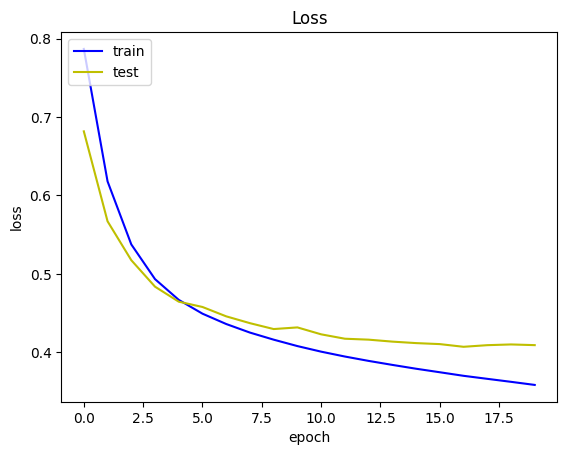

In [ ]:
plt.plot(history.history['loss'],c='b')
plt.plot(history.history['val_loss'],c='y')
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()